## Importing UCIML Car Dataset

In [53]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import adjusted_rand_score, accuracy_score

In [54]:
cars = fetch_ucirepo(id=19) 
X = cars.data.features 
y = cars.data.targets 

In [55]:
print(X)

     buying  maint  doors persons lug_boot safety
0     vhigh  vhigh      2       2    small    low
1     vhigh  vhigh      2       2    small    med
2     vhigh  vhigh      2       2    small   high
3     vhigh  vhigh      2       2      med    low
4     vhigh  vhigh      2       2      med    med
...     ...    ...    ...     ...      ...    ...
1723    low    low  5more    more      med    med
1724    low    low  5more    more      med   high
1725    low    low  5more    more      big    low
1726    low    low  5more    more      big    med
1727    low    low  5more    more      big   high

[1728 rows x 6 columns]


In [56]:
print(y)

      class
0     unacc
1     unacc
2     unacc
3     unacc
4     unacc
...     ...
1723   good
1724  vgood
1725  unacc
1726   good
1727  vgood

[1728 rows x 1 columns]


## Pre-Processing Of Data

In [78]:
def preprocess_car_evaluation(X, y):
    # Encode categorical features and target variable
    X_encoded = pd.get_dummies(X)  # One-hot encoding for features
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)  # Encode target
    
    # Dynamically create a consistent class mapping
    dynamic_mapping = {index: label for index, label in enumerate(le.classes_)}
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)
    
    return X_scaled, y_encoded, dynamic_mapping

# Fetch and preprocess the data
X_preprocessed, y_preprocessed, dynamic_mapping = preprocess_car_evaluation(X, y)

# Overwrite predefined class_mapping dynamically to match LabelEncoder
class_mapping = dynamic_mapping

# Print mappings to confirm consistency
print("Dynamic Mapping:", dynamic_mapping)
print("Class Mapping (Updated):", class_mapping)


Dynamic Mapping: {0: 'acc', 1: 'good', 2: 'unacc', 3: 'vgood'}
Class Mapping (Updated): {0: 'acc', 1: 'good', 2: 'unacc', 3: 'vgood'}


c:\Users\mysto\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Unsupervised Learning : K-Means Clustering

In [79]:
# Step 3: K-Means Clustering Function
def kmeans_clustering(X, y):
    # Perform K-Means Clustering
    kmeans = KMeans(n_clusters=len(set(y)), init='k-means++', random_state=42)
    y_pred = kmeans.fit_predict(X)
    
    # Evaluate clustering performance
    ari = adjusted_rand_score(y, y_pred)
    silhouette = silhouette_score(X, y_pred)
    
    return kmeans, y_pred, ari, silhouette

In [80]:
# Step 4: Apply K-Means and Evaluate
kmeans, kmeans_labels, kmeans_ari, kmeans_silhouette = kmeans_clustering(X_preprocessed, y_preprocessed)

In [81]:
# Step 5: Print Results
print("K-Means Clustering (Unsupervised) ARI:", kmeans_ari)

K-Means Clustering (Unsupervised) ARI: 0.000729652868196255


## Supervised Learning - Logistic Regression

In [82]:
from sklearn.metrics import classification_report, confusion_matrix


def logistic_regression(X, y):
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train logistic regression model
    clf = LogisticRegression(random_state=42, max_iter=500)
    clf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    confusion = confusion_matrix(y_test, y_pred)
    
    return clf, acc, report, confusion, X_train, X_test, y_train, y_test

In [83]:
# Call the function and get outputs
clf, logistic_accuracy, logistic_report, logistic_confusion, X_train, X_test, y_train, y_test = logistic_regression(X_preprocessed, y_preprocessed)

# Print results
print("Logistic Regression Accuracy:", logistic_accuracy)

Logistic Regression Accuracy: 0.928709055876686


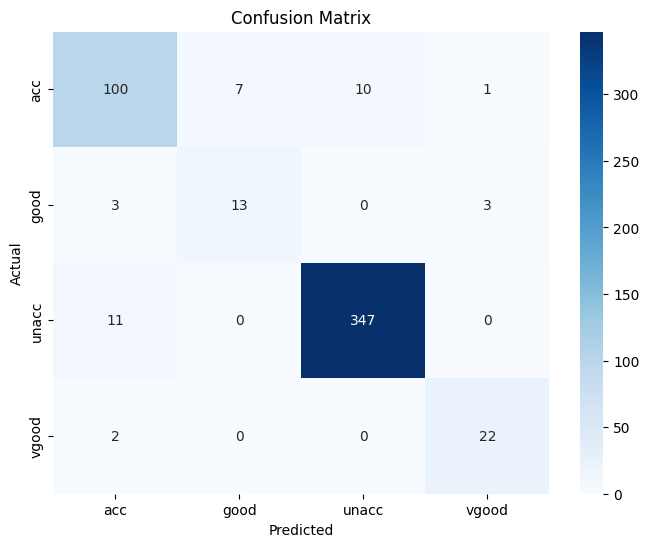

In [84]:
# Step 6: Visualize Confusion Matrix
def plot_confusion_matrix(confusion, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(logistic_confusion, list(class_mapping.values()))

In [85]:
print(f"Logistic Regression (Supervised) Accuracy: {logistic_accuracy}")
print("Classification Report (Logistic Regression):")
print(pd.DataFrame(logistic_report).transpose())

Logistic Regression (Supervised) Accuracy: 0.928709055876686
Classification Report (Logistic Regression):
              precision    recall  f1-score     support
0              0.862069  0.847458  0.854701  118.000000
1              0.650000  0.684211  0.666667   19.000000
2              0.971989  0.969274  0.970629  358.000000
3              0.846154  0.916667  0.880000   24.000000
accuracy       0.928709  0.928709  0.928709    0.928709
macro avg      0.832553  0.854402  0.842999  519.000000
weighted avg   0.929391  0.928709  0.928953  519.000000


## Final Comments

The Car Evaluation dataset was analyzed using both unsupervised and supervised learning methods. The unsupervised learning model, K-Means Clustering, produced an Adjusted Rand Index (ARI) of **0.0007**. These results indicate that the clusters formed by K-Means do not align well with the true class labels, and the clustering quality is poor. This is likely due to the categorical nature of the dataset and the limitations of using Euclidean distance in K-Means after one-hot encoding. The dataset does not exhibit natural clusters, making K-Means unsuitable for this task.

In contrast, the supervised learning model, Logistic Regression, achieved an overall accuracy of **92.87%**, demonstrating strong performance. The model effectively classified the majority classes (good and unacc), achieving high precision and recall for these categories. The minority classes (acc and vgood) were more challenging to classify, with lower precision and recall due to their smaller sample sizes and potential feature overlap. For example, the acc class achieved a precision of **65%** and a recall of **68.4%**, reflecting some misclassification issues. Despite this, the model maintained a balanced performance across all classes, as evidenced by a macro F1-score of **84.3%** and a weighted F1-score of **92.9%**.

Overall, Logistic Regression significantly outperformed K-Means Clustering for this dataset, demonstrating that the structured and categorical nature of the data is better suited to supervised learning methods. Addressing class imbalance or exploring clustering algorithms tailored for categorical data, such as K-Prototypes, could further improve performance.